### Defect  Detection On Metal Surface

### TEAM NO. 7  

1. Yallappa Avaradi , 112   ,    01fe19bme170
2. Abhishek Badi    , 113    ,   01fe19bme180
3. Rizwan Sayyed    , 114   ,    01fe19bme181

#### Objective

This project focus on detecting the type of metal surface defect which will help for better quality
productions of Metals for the industries,building a deep learning model which detects the type of defect
on metal surface produced

#### Dataset Description

The dataset GC10-DET is collected from upcoming paper " Deep Metallic Surface Defect Detection: the New Benchmark and Detection Network" . The images of 10 common Metallic Surface defects were collected, and their box level ground-truth were labeled.
The dataset includes 3570 gray-scale images.

- Punching: In the production line of the strip, the steel strip needs to be punched according to the
product specifications; mechanical failure may lead to unwanted punching, resulting in punching
defects.
- Welding line: When the strip is changed, it is necessary to weld the two coils of the strip, and the
weld line is produced. Strictly speaking, this is not a defect, but it needs to be automatically
detected and tracked to be circumvented in subsequent cuts.
- Crescent gap: In the production of steel strip, cutting sometimes results in defects, just like half
a circle.
- Water spot: A water spot is produced by drying in production. Under different products and
processes, the requirements for this defect are different. However, because the water spots are
generally with low contrast, and are similar to other defects such as oil spots, they are usually
detected by mistake.
- Oil spot: An oil spot is usually caused by the contamination of mechanical lubricant, which will
affect the appearance of the product.
Silk spot: A local or continuous wave-like plaque on a strip surface that may appear on the upper
and lower surfaces, and the density is uneven in the whole strip length direction. Generally,
the main reason lies in the uneven temperature of the roller and uneven pressure.
- Inclusion: Inclusion is a typical defect of metal surface defects, usually showing small spots,
fish scale shape, strip shape, block irregular distribution in the strip of the upper and lower surface
(global or local), and is often accompanied by rough pockmarked surfaces. Some inclusions are
loose and easy to fall off and some are pressed into the plate.
- Rolled pit: Rolled pits are periodic bulges or pits on the surface of a steel plate that are punctate,
flaky, or strip-like. They are distributed throughout the strip length or section, mainly caused by
work roll or tension roll damage.
- Crease: A crease is a vertical transverse fold, with regular or irregular spacing across the strip, or
at the edge of the strip. The main reason is the local yield along the moving direction of the strip
in the uncoiling process.
- Waist folding: There are obvious folds in the defect parts, a little more popular, a little like
wrinkles, indicating that the local deformation of the defect is too large. The reason is due to
low-carbon.

## Table of Contents

- [1 - Packages](#1)
- [2 - Data Importing](#2)
- [3 - Data Splitting](#3)
- [4 - Data Preprocessing and Augmentation](#4)
- [4 - Methdology](#5)
- [6 - Building Sequential Model](#6)
- [7 - Plotting Accuracy and loss graphs over epochs](#7)
- [8 - Actual v/s Predicted Outputs](#8)
- [9 - Using Pretrained Model: ResNet](#9)
- [10 - Conclusion](#10)

<a name='1'></a>
### 1 - Packages

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Add,Dense,Flatten

In [2]:
image_size = 256
BATCH_SIZE = 32

<a name ='2'></a>
### 2 - Data Importing


In [3]:
df = tf.keras.preprocessing.image_dataset_from_directory(
  r"C:\Users\R_JONAH\Downloads\archive (2)\images\images", 
  shuffle=True,
  image_size=(image_size,image_size),
  batch_size=BATCH_SIZE
)

Found 2306 files belonging to 10 classes.


In [4]:
class_names = df.class_names
class_names

['crease',
 'crescent_gap',
 'inclusion',
 'oil_spot',
 'punching_hole',
 'rolled_pit',
 'silk_spot',
 'waist folding',
 'water_spot',
 'welding_line']

Below code shows there are 73 batches of mini batch size of 32

In [5]:
len(df)

73

In [8]:
for image_batch, label_batch in df.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[9 1 6 6 2 9 6 9 8 3 6 4 6 7 8 8 9 7 6 1 6 8 3 4 4 6 9 3 6 5 6 6]


In [9]:
for image_batch, label_batch in df.take(1):
  print(image_batch[0].shape)

(256, 256, 3)


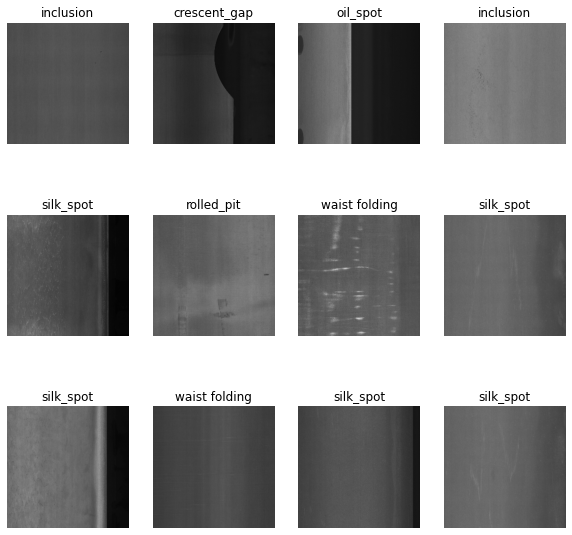

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in df.take(1):
  for i in range (12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))  
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

<a name = '3'></a>
### 3 - Data Splitting

Dataset should be divided into 3 subsets,namely:

1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [11]:
def ge_dataset_partitions_tf(ds, train_split=.6, val_split=.3, test_split=.1,shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  triain_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return triain_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = ge_dataset_partitions_tf(df)

In [13]:
print("No of batches for training:",len(train_ds))
print("No of batches for validation:",len(val_ds)) 
print("No of batches for testing:",len(test_ds))

No of batches for training: 43
No of batches for validation: 21
No of batches for testing: 9


<a name = '4'></a>
### 4 - Data Preprocessing and Augmentation

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 255). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [14]:
resize_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(image_size,image_size),
      layers.experimental.preprocessing.Rescaling(1./255)  
])

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

<a name = '5'></a> 
### 5 - Methdology

- Using Sequential API from keras library to build the CNN Model
- Increasing no of layers conv, pooling and fuly connected layers with more no of neurons to increase the accuracy of the     model, for classification
  using softmax as activation function at the output layer and relu function at all conv layers
- Increase the no of epochs to check the accuracy increase
- Using sparse categorical crossentropy as loss function which is best classification problems for classes more than 4
- Using Pretrained model from keras.applications library 
- compairing the accuracies of model trained and predicted 


<a name = 5></a>
### 6 - Building Sequential Model

In [24]:
input_shape = (BATCH_SIZE,image_size, image_size, 3)


In [32]:
model = tf.keras.models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),


    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax') 
    ])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_73 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_73 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_74 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [174]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
 )

In [52]:
import warnings
warnings.filterwarnings('ignore')

In [176]:
EPOCHS = 100
history = model.fit(
    train_ds,
    verbose=1,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/100
43/43 [==============================] - 104s 2s/step - loss: 2.1118 - accuracy: 0.2697 - val_loss: 2.0370 - val_accuracy: 0.2932
Epoch 2/100
43/43 [==============================] - 113s 2s/step - loss: 2.0149 - accuracy: 0.2756 - val_loss: 1.9753 - val_accuracy: 0.2932
Epoch 3/100
43/43 [==============================] - 107s 2s/step - loss: 1.9290 - accuracy: 0.2994 - val_loss: 1.8988 - val_accuracy: 0.3140
Epoch 4/100
43/43 [==============================] - 105s 2s/step - loss: 1.9250 - accuracy: 0.2883 - val_loss: 1.9090 - val_accuracy: 0.2842
Epoch 5/100
43/43 [==============================] - 105s 2s/step - loss: 1.8818 - accuracy: 0.3061 - val_loss: 1.8431 - val_accuracy: 0.3240
Epoch 6/100
43/43 [==============================] - 107s 2s/step - loss: 1.8557 - accuracy: 0.3110 - val_loss: 1.8444 - val_accuracy: 0.3185
Epoch 7/100
43/43 [==============================] - 104s 2s/step - loss: 1.8505 - accuracy: 0.2987 - val_loss: 1.7991 - val_accuracy: 0.3438
Epoch 

In [177]:
loss,accuracy= model.evaluate(test_ds)
print("loss:",loss)
print("accuracy:",accuracy)

9/9 [==============================] - 12s 381ms/step - loss: 0.9716 - accuracy: 0.6389
loss: 0.9716361165046692
accuracy: 0.6388888955116272


In [53]:
model1 = tf.keras.models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
     
    


    layers.Flatten(),
    layers.Dense(124, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(124, activation='relu'),
    layers.Dense(10, activation='softmax') 
    ])

model1.build(input_shape=input_shape)

In [54]:
model1.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_114 (Conv2D)         (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_114 (MaxPooli  (32, 127, 127, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_115 (Conv2D)         (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_115 (MaxPooli  (32, 62, 62, 64)         0         
 ng2D)                                               

In [55]:
model1.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
 )

In [56]:
EPOCHS = 100
history1 = model1.fit(
    train_ds,
    verbose=1,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/100
43/43 [==============================] - 108s 2s/step - loss: 2.0866 - accuracy: 0.2922 - val_loss: 2.1318 - val_accuracy: 0.2768
Epoch 2/100
43/43 [==============================] - 102s 2s/step - loss: 2.1024 - accuracy: 0.2667 - val_loss: 2.0167 - val_accuracy: 0.2819
Epoch 3/100
43/43 [==============================] - 112s 2s/step - loss: 1.9978 - accuracy: 0.2762 - val_loss: 1.8942 - val_accuracy: 0.3185
Epoch 4/100
43/43 [==============================] - 116s 2s/step - loss: 1.9103 - accuracy: 0.2875 - val_loss: 1.8653 - val_accuracy: 0.3022
Epoch 5/100
43/43 [==============================] - 108s 2s/step - loss: 1.8731 - accuracy: 0.3132 - val_loss: 1.8867 - val_accuracy: 0.3051
Epoch 6/100
43/43 [==============================] - 101s 2s/step - loss: 1.8608 - accuracy: 0.2994 - val_loss: 1.8943 - val_accuracy: 0.3110
Epoch 7/100
43/43 [==============================] - 101s 2s/step - loss: 1.8742 - accuracy: 0.2912 - val_loss: 1.8342 - val_accuracy: 0.2632
Epoch 

In [178]:
 history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<a name = '7'></a>
### 7 - Plotting accuracy and loss graphs  over epochs

In [179]:
def graph(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    EPOCHS = history.epoch
    
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    
    plt.plot(EPOCHS, train_acc, label='Training Accuracy')
    plt.plot(EPOCHS, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validaton Accuracy')

    plt.subplot(1,2,2)
    plt.plot(EPOCHS, train_loss, label='Training loss')
    plt.plot(EPOCHS, val_loss, label='Vlidation loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validaton loss')

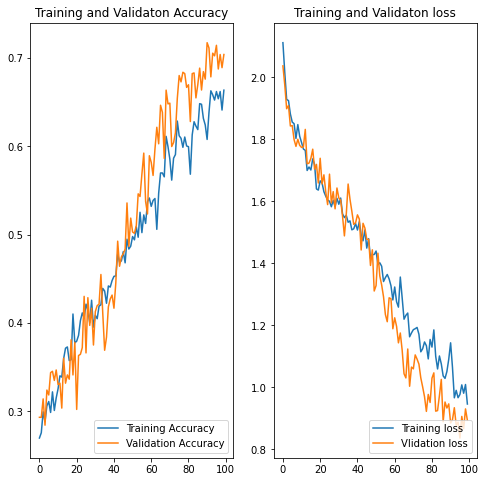

In [180]:
graph(history)

Image to predict
Actual label: silk_spot
Predicted label: silk_spot


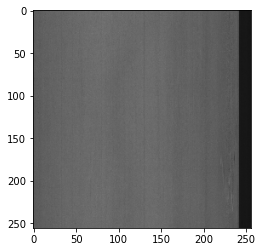

In [181]:
for image_batch, label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype('uint8')
  first_label=label_batch[0].numpy()

  print('Image to predict')
  plt.imshow(first_image)
  print('Actual label:', class_names[first_label])

  batch_preiction = model.predict(image_batch)
  print('Predicted label:', class_names[np.argmax(batch_preiction[0])])

<a name = '8'></a>
### 8 - Actual v/s Predicted outputs

In [134]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    #print(img_array)
    img_array = tf.expand_dims(img_array, 0) 


    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

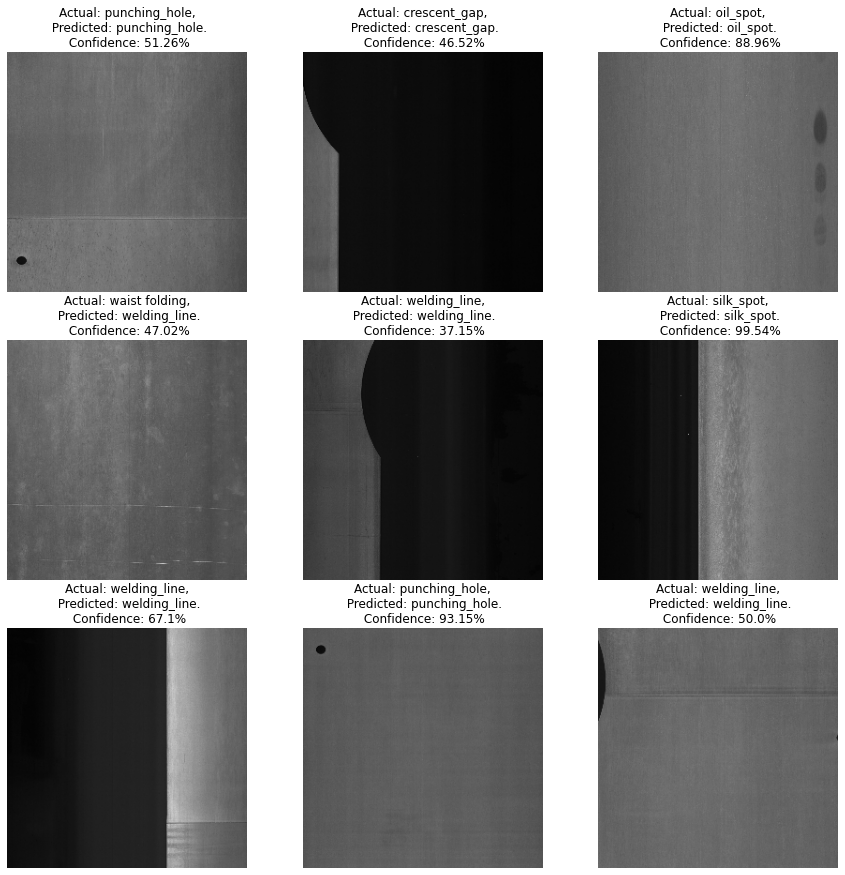

In [182]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

<a name = '9'></a>
### 9 - Using  Pretrained Model : Resnet

In [183]:
resnet_model = tf.keras.models.Sequential()
pretrained_model= tf.keras.applications.resnet50.ResNet50(
                  include_top= False,
                  weights='imagenet',
                  classes = 10,
                  pooling= 'avg',
                  input_shape = (256,256,3)
                  )
for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation ='relu'))
resnet_model.add(Dense(10,activation = 'softmax'))

In [184]:
resnet_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_17 (Flatten)        (None, 2048)              0         
                                                                 
 dense_31 (Dense)            (None, 512)               1049088   
                                                                 
 dense_32 (Dense)            (None, 10)                5130      
                                                                 
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [185]:
resnet_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
 )

In [186]:
hist = resnet_model.fit(train_ds,epochs=20,validation_data=val_ds,verbose = 1)

Epoch 1/20
43/43 [==============================] - 242s 5s/step - loss: 1.2594 - accuracy: 0.5780 - val_loss: 0.7103 - val_accuracy: 0.7693
Epoch 2/20
43/43 [==============================] - 239s 5s/step - loss: 0.5478 - accuracy: 0.8219 - val_loss: 0.4896 - val_accuracy: 0.8378
Epoch 3/20
43/43 [==============================] - 242s 5s/step - loss: 0.5305 - accuracy: 0.8234 - val_loss: 0.5144 - val_accuracy: 0.8185
Epoch 4/20
43/43 [==============================] - 239s 5s/step - loss: 0.4800 - accuracy: 0.8351 - val_loss: 0.4360 - val_accuracy: 0.8348
Epoch 5/20
43/43 [==============================] - 234s 5s/step - loss: 0.3956 - accuracy: 0.8612 - val_loss: 0.3481 - val_accuracy: 0.8720
Epoch 6/20
43/43 [==============================] - 239s 5s/step - loss: 0.3085 - accuracy: 0.8871 - val_loss: 0.2729 - val_accuracy: 0.8973
Epoch 7/20
43/43 [==============================] - 263s 6s/step - loss: 0.3340 - accuracy: 0.8848 - val_loss: 0.2373 - val_accuracy: 0.9196
Epoch 8/20
43

In [187]:
loss2,accuracy2= resnet_model.evaluate(test_ds)
print("loss:",loss2)
print("accuracy:",accuracy2)

9/9 [==============================] - 43s 4s/step - loss: 0.1164 - accuracy: 0.9583
loss: 0.11638692021369934
accuracy: 0.9583333134651184


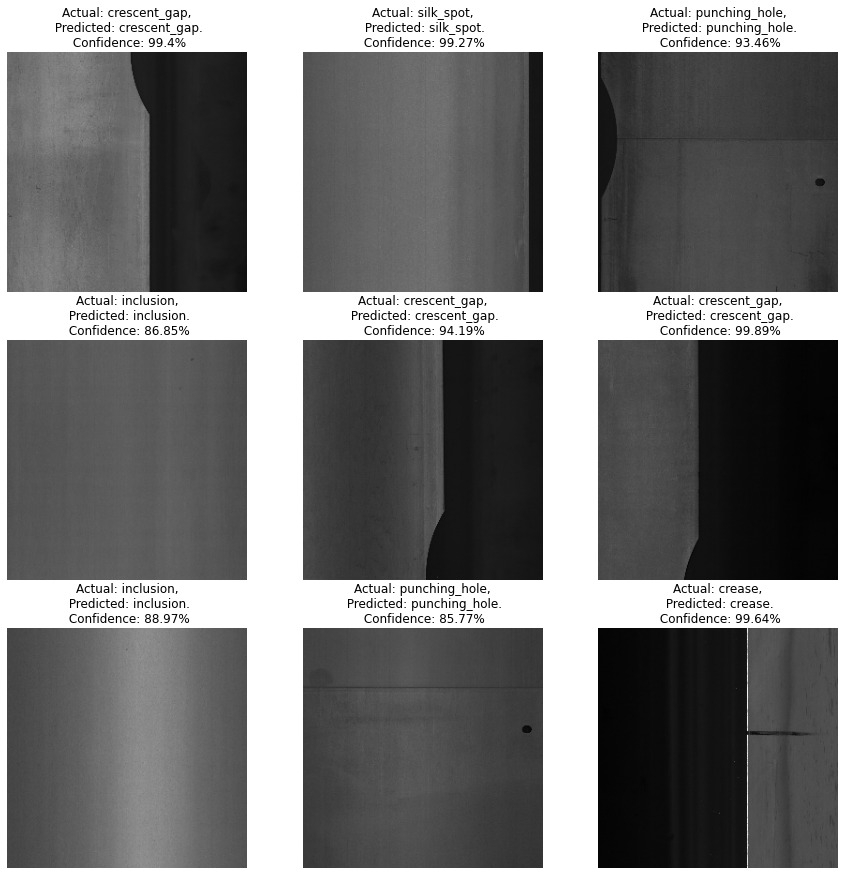

In [188]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(resnet_model,images[i].numpy())

        actual_class = class_names[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

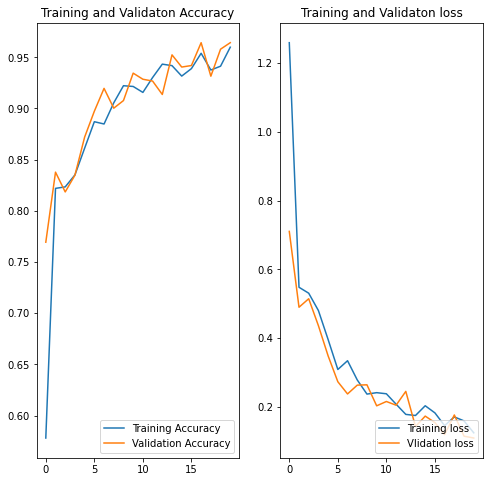

In [189]:
graph(hist)

<a name = '10'></a>
### 10 - Conclusion

According to the above results we can see that pretrained model ResNet50 has got maximum accuracy of 96% ,the trainig and validation loss and accuracy respectively are varying in similar manner to that of conventional Sequential models we have built and imporved the model accuracy by some percent,1st model has got accuarcy of 64% and 2nd one has got 71% after varying parameters of the model